In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-02-21 15:18:51'

# wip

In [2]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [4]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [5]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db1 = DbAccessor('hshah1_0020_binary_mnist', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)

In [6]:
pd.read_sql(f'select * from runs', db1.conn)

,ITI,features,freq,lambda,name,run,seed,step_size,steps,width
0,10,64,10000000,0.00,0020_binary_mnist,0,0,0.3,2100000,200
1,10,64,10000000,0.50,0020_binary_mnist,1,0,0.3,2100000,200
2,10,64,10000000,0.90,0020_binary_mnist,2,0,0.3,2100000,200
3,10,64,10000000,0.99,0020_binary_mnist,3,0,0.3,2100000,200
4,10,64,10000000,0.00,0020_binary_mnist,4,1,0.3,2100000,200
...,...,...,...,...,...,...,...,...,...,...
2435,10,64,400000,0.99,0020_binary_mnist,4535,3,0.1,2100000,10
2436,10,64,400000,0.00,0020_binary_mnist,4536,4,0.1,2100000,10
2437,10,64,400000,0.50,0020_binary_mnist,4537,4,0.1,2100000,10
2438,10,64,400000,0.90,0020_binary_mnist,4538,4,0.1,2100000,10


In [7]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'error'
    else:
        col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        #plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.2, color=color, edgecolor=color)
    return True

In [8]:
p1 = pd.read_sql(f'select distinct(step_size) from runs', db1.conn).values.squeeze()
p2 = pd.read_sql(f'select distinct(lambda) from runs', db1.conn).values.squeeze()
p3 = pd.read_sql(f'select distinct(freq) from runs', db1.conn).values.squeeze()
p4 = pd.read_sql(f'select distinct(width) from runs', db1.conn).values.squeeze()
print(['step_size', 'lambda', 'freq', 'width'])
list(itertools.product(p1,p2)),list(itertools.product(p3,p4))

['step_size', 'lambda', 'freq', 'width']


([(0.3, 0.0),
  (0.3, 0.5),
  (0.3, 0.9),
  (0.3, 0.99),
  (0.1, 0.0),
  (0.1, 0.5),
  (0.1, 0.9),
  (0.1, 0.99),
  (0.03, 0.0),
  (0.03, 0.5),
  (0.03, 0.9),
  (0.03, 0.99),
  (0.01, 0.0),
  (0.01, 0.5),
  (0.01, 0.9),
  (0.01, 0.99),
  (0.003, 0.0),
  (0.003, 0.5),
  (0.003, 0.9),
  (0.003, 0.99),
  (0.001, 0.0),
  (0.001, 0.5),
  (0.001, 0.9),
  (0.001, 0.99),
  (0.0003, 0.0),
  (0.0003, 0.5),
  (0.0003, 0.9),
  (0.0003, 0.99)],
 [(10000000, 200),
  (10000000, 1),
  (10000000, 10),
  (10000000, 20),
  (10000, 200),
  (10000, 1),
  (10000, 10),
  (10000, 20),
  (200000, 200),
  (200000, 1),
  (200000, 10),
  (200000, 20),
  (50000, 200),
  (50000, 1),
  (50000, 10),
  (50000, 20),
  (100000, 200),
  (100000, 1),
  (100000, 10),
  (100000, 20),
  (400000, 200),
  (400000, 1),
  (400000, 10),
  (400000, 20)])

In [9]:
pd.read_sql(f'select distinct(freq) from runs where width=20', db1.conn).values.squeeze()

array([200000, 400000])

(0.0003, 0.0) :	 [0.020692, 0.021583, 0.020788, 0.020492, 0.019725, 0.021067, 0.018483, 0.020799, 0.020271, 0.023057]
(0.0003, 0.5) :	 [0.018748, 0.018497, 0.01963, 0.018905, 0.018396, 0.018992, 0.017709, 0.019083, 0.017621, 0.020391]
(0.0003, 0.9) :	 [0.017941, 0.018705, 0.017676, 0.017494, 0.016907, 0.018449, 0.016832, 0.017984, 0.016662, 0.019117]
(0.0003, 0.99) :	 [0.017428, 0.018457, 0.016839, 0.017021, 0.016953, 0.018394, 0.016396, 0.017828, 0.016769, 0.019341]
(0.001, 0.0) :	 [0.019057, 0.017939, 0.020034, 0.018664, 0.017842, 0.01855, 0.017888, 0.019842, 0.01765, 0.019882]
(0.001, 0.5) :	 [0.017859, 0.018067, 0.017489, 0.017421, 0.016963, 0.018012, 0.016185, 0.018659, 0.017832, 0.020471]
(0.001, 0.9) :	 [0.016938, 0.017828, 0.016783, 0.017518, 0.016677, 0.018115, 0.015935, 0.01806, 0.01691, 0.018395]
(0.001, 0.99) :	 [0.017614, 0.017642, 0.016106, 0.016953, 0.016401, 0.016901, 0.01582, 0.017713, 0.016, 0.01766]
(0.003, 0.0) :	 [0.018265, 0.018401, 0.018425, 0.018007, 0.018035, 0

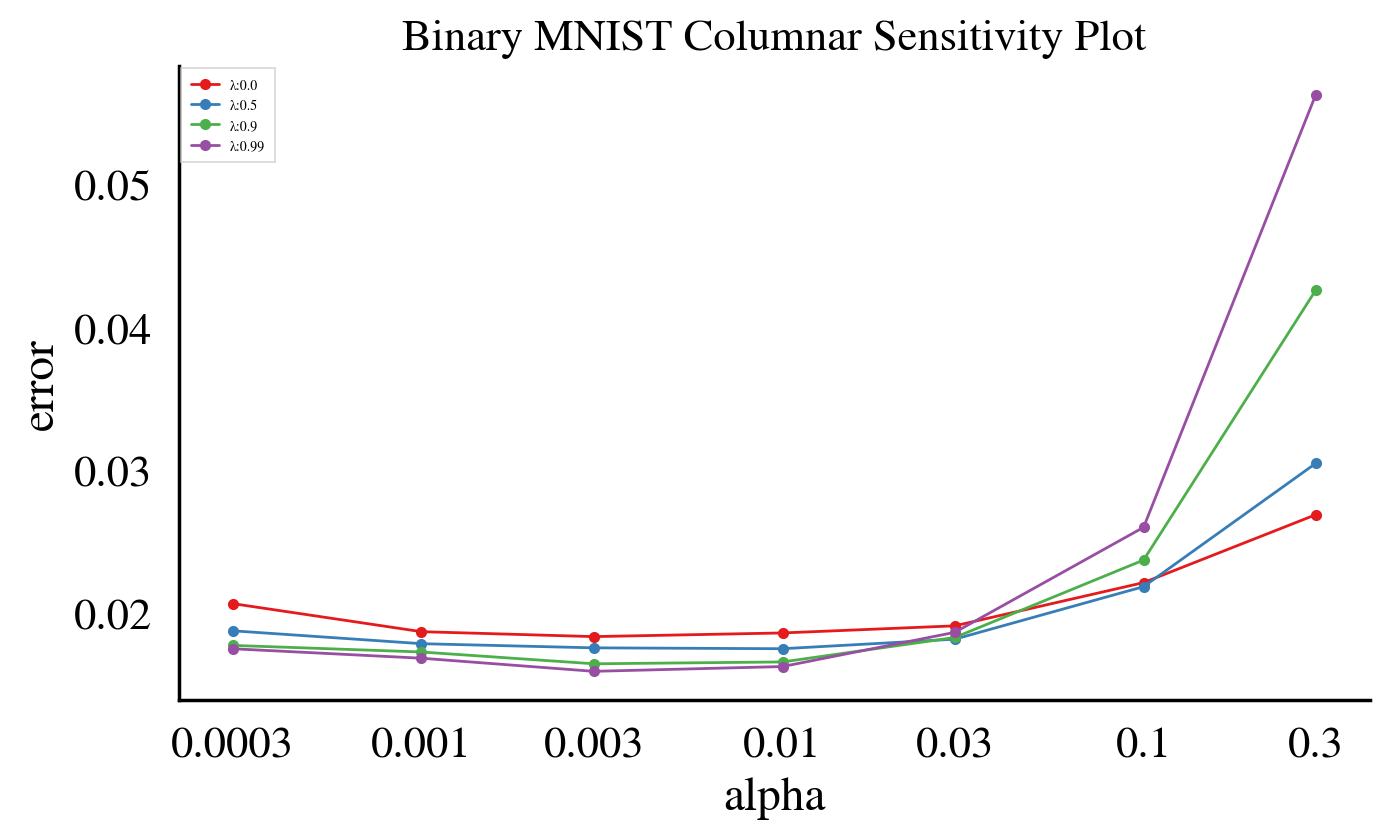

In [10]:
plt_name = f'Binary MNIST Columnar Sensitivity Plot'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
color_idx = 0

mean_errors = []
runs = pd.read_sql(f'select run, step_size, lambda from runs where width=200', db1.conn)
p1 = np.unique(runs.values[:,1])
p2 = np.unique(runs.values[:,2])
for p in itertools.product(p1,p2):
    all_errors = []
    r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
    for run in r["run"].values:
        final_error = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values[400][0]
        all_errors.append(final_error)
    all_errors = list(filter(lambda v: v==v, all_errors))
    mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
    print(p, ":\t", all_errors)
#pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
r["run"].values
mean_errors = np.array(mean_errors)

for p in p2:
    values = mean_errors[mean_errors[:,1] == p]
    plt.plot(values[:,0], values[:,2], label=f"λ:{p}", color=colors[color_idx], linewidth=1, marker='.')
    color_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')

In [11]:
len(pd.read_sql(f'select error from error_table where run={run}', db1.conn).values)

417

(0.0003, 0.0) :	 10000 	 [0.025274, 0.026319, 0.025565, 0.026199, 0.025592, 0.027435, 0.024711, 0.025841, 0.025385, 0.027179]
(0.0003, 0.5) :	 10000 	 [0.024406, 0.02603, 0.024813, 0.025253, 0.025017, 0.0265, 0.023596, 0.025487, 0.024525, 0.02625]
(0.0003, 0.9) :	 10000 	 [0.024338, 0.02511, 0.024065, 0.024389, 0.024212, 0.026514, 0.023203, 0.025691, 0.023655, 0.02583]
(0.0003, 0.99) :	 10000 	 [0.024239, 0.024795, 0.023884, 0.024232, 0.023879, 0.026279, 0.022884, 0.025269, 0.022908, 0.025766]
(0.001, 0.0) :	 10000 	 [0.026973, 0.024582, 0.02545, 0.025051, 0.027144]
(0.001, 0.5) :	 10000 	 [0.025348, 0.023393, 0.024146, 0.023342, 0.02591]
(0.001, 0.9) :	 10000 	 [0.024543, 0.021824, 0.023484, 0.022884, 0.024737]
(0.001, 0.99) :	 10000 	 [0.023944, 0.021042, 0.023681, 0.021106, 0.024987]
(0.003, 0.0) :	 10000 	 [0.023486, 0.024318, 0.02487, 0.024811, 0.024001]
(0.003, 0.5) :	 10000 	 [0.022661, 0.02271, 0.023212, 0.022626, 0.022382]
(0.003, 0.9) :	 10000 	 [0.021567, 0.021723, 0.021773,

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.01, 0.0) :	 50000 	 []
(0.01, 0.5) :	 50000 	 []
(0.01, 0.9) :	 50000 	 []
(0.01, 0.99) :	 50000 	 []
(0.03, 0.0) :	 50000 	 [0.020925, 0.021559, 0.021608, 0.020016, 0.019077, 0.020339, 0.019755, 0.0219, 0.020979, 0.023854]
(0.03, 0.5) :	 50000 	 [0.019259, 0.01899, 0.019667, 0.019034, 0.019038, 0.020501, 0.017978, 0.020097, 0.018808, 0.020724]
(0.03, 0.9) :	 50000 	 [0.019305, 0.018648, 0.019101, 0.019178, 0.01925, 0.020486, 0.019256, 0.019834, 0.018631, 0.020702]
(0.03, 0.99) :	 50000 	 [0.019485, 0.019492, 0.019004, 0.019787, 0.019703, 0.020957, 0.017938, 0.02093, 0.018311, 0.021779]
(0.1, 0.0) :	 50000 	 [0.021172, 0.022041, 0.021023, 0.020772, 0.019133, 0.021619, 0.019505, 0.021074, 0.019399, 0.023462]
(0.1, 0.5) :	 50000 	 [0.02123, 0.020931, 0.021811, 0.021482, 0.021764, 0.023492, 0.018943, 0.022114, 0.020096, 0.0223]
(0.1, 0.9) :	 50000 	 [0.025341, 0.024335, 0.023369, 0.023413, 0.025066, 0.026348, 0.023363, 0.02493, 0.022496, 0.02769]
(0.1, 0.99) :	 50000 	 [0.02674, 0.0272

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.01, 0.0) :	 100000 	 []
(0.01, 0.5) :	 100000 	 []
(0.01, 0.9) :	 100000 	 []
(0.01, 0.99) :	 100000 	 []
(0.03, 0.0) :	 100000 	 [0.019476, 0.018922, 0.019761, 0.018916, 0.019578, 0.020296, 0.017484, 0.020768, 0.017567, 0.020943]
(0.03, 0.5) :	 100000 	 [0.018398, 0.019363, 0.018592, 0.018689, 0.018304, 0.019599, 0.016944, 0.019381, 0.017662, 0.020171]
(0.03, 0.9) :	 100000 	 [0.018595, 0.018323, 0.018824, 0.01867, 0.017978, 0.020278, 0.015659, 0.018789, 0.016329, 0.020274]
(0.03, 0.99) :	 100000 	 [0.019556, 0.018031, 0.01867, 0.019061, 0.019631, 0.020644, 0.01628, 0.018617, 0.018013, 0.021647]
(0.1, 0.0) :	 100000 	 [0.020772, 0.020301, 0.021113, 0.020215, 0.020579, 0.02108, 0.019036, 0.020791, 0.020472, 0.021714]
(0.1, 0.5) :	 100000 	 [0.021802, 0.023247, 0.020402, 0.021309, 0.020524, 0.02222, 0.020561, 0.020773, 0.019945, 0.023733]
(0.1, 0.9) :	 100000 	 [0.023524, 0.021361, 0.022558, 0.02385, 0.023421, 0.024443, 0.024215, 0.02353, 0.022336, 0.027295]
(0.1, 0.99) :	 100000 	 [

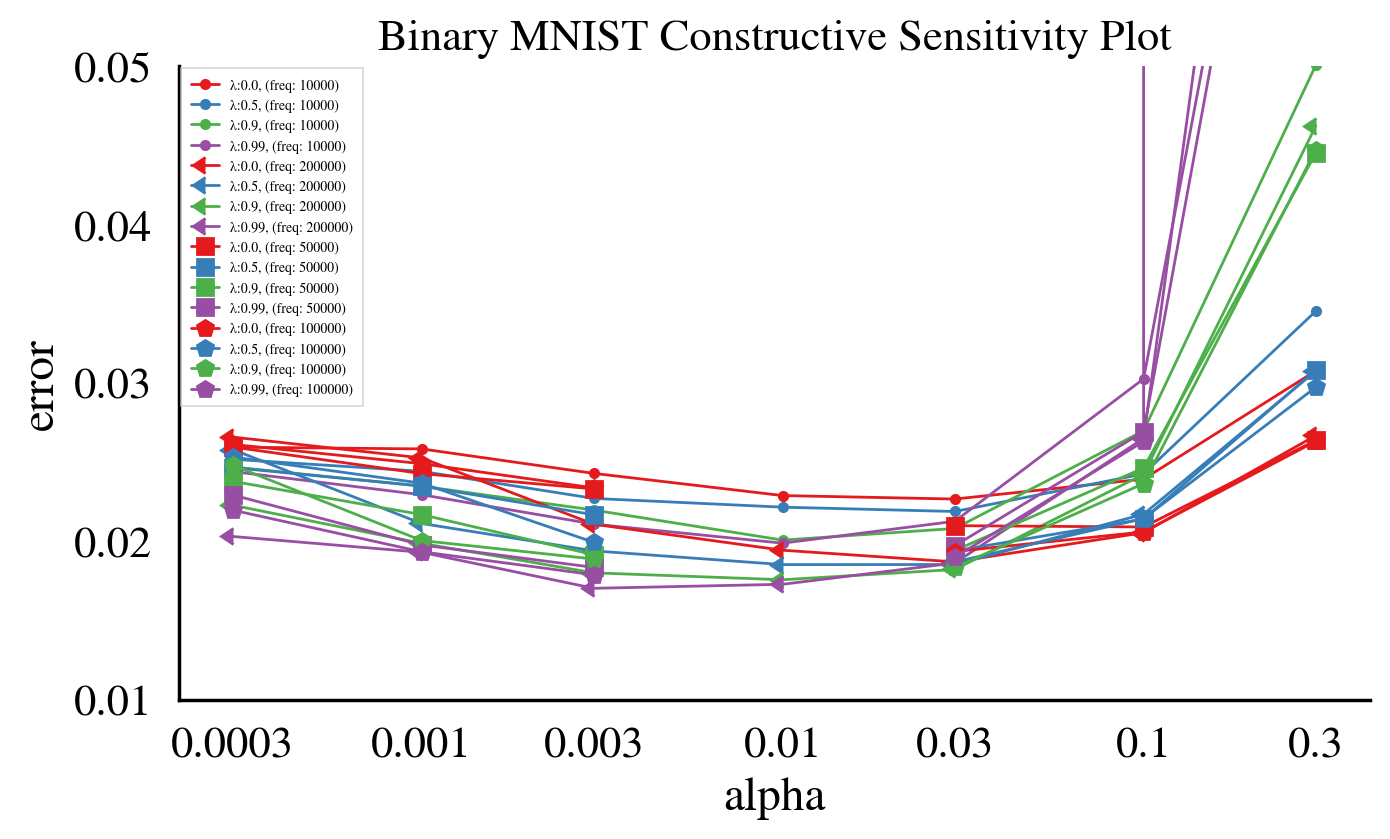

In [12]:
markers = ['.',8,'s','p','*','h']

marker_idx = 0

plt_name = f'Binary MNIST Constructive Sensitivity Plot'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width=1', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width=1 and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 400:
                all_errors.append(errors_list[400][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.01, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.show()

In [13]:
pd.read_sql(f'select run, step_size, lambda from runs where width=1 and freq={400000}', db1.conn)

,run,step_size,lambda


(0.0003, 0.0) :	 200000 	 [0.024319, 0.022237, 0.023404, 0.022917, 0.023285, 0.02326, 0.022298, 0.023635, 0.023576, 0.025313]
(0.0003, 0.5) :	 200000 	 [0.022415, 0.022033, 0.022264, 0.021362, 0.022206, 0.022894, 0.020781, 0.02287, 0.022273, 0.025799]
(0.0003, 0.9) :	 200000 	 [0.020021, 0.019623, 0.019914, 0.019704, 0.019081, 0.020952, 0.018371, 0.020153, 0.019555, 0.021667]
(0.0003, 0.99) :	 200000 	 [0.019907, 0.018847, 0.018872, 0.018587, 0.018197, 0.019645, 0.017353, 0.019333, 0.017908, 0.020668]
(0.001, 0.0) :	 200000 	 [0.022644, 0.021747, 0.022963, 0.022219, 0.020689, 0.022529, 0.019965, 0.0218, 0.022155, 0.023532]
(0.001, 0.5) :	 200000 	 [0.020177, 0.01938, 0.020351, 0.019712, 0.019392, 0.020937, 0.018217, 0.019957, 0.018689, 0.021376]
(0.001, 0.9) :	 200000 	 [0.018529, 0.017667, 0.018719, 0.017728, 0.016936, 0.018051, 0.016679, 0.018677, 0.017089, 0.019077]
(0.001, 0.99) :	 200000 	 [0.018163, 0.017286, 0.017175, 0.017099, 0.017117, 0.017986, 0.016385, 0.017436, 0.016824, 0

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.003, 0.0) :	 200000 	 []
(0.003, 0.5) :	 200000 	 []
(0.003, 0.9) :	 200000 	 []
(0.003, 0.99) :	 200000 	 []
(0.01, 0.0) :	 200000 	 []
(0.01, 0.5) :	 200000 	 []
(0.01, 0.9) :	 200000 	 []
(0.01, 0.99) :	 200000 	 []
(0.03, 0.0) :	 200000 	 [0.017767, 0.017768, 0.016445, 0.016638, 0.016832, 0.01792, 0.015923, 0.017312, 0.016403, 0.017923]
(0.03, 0.5) :	 200000 	 [0.017881, 0.017328, 0.016943, 0.017216, 0.016272, 0.018047, 0.015267, 0.017609, 0.016829, 0.018655]
(0.03, 0.9) :	 200000 	 [0.017049, 0.018041, 0.017057, 0.017102, 0.017203, 0.018051, 0.015147, 0.016505, 0.016027, 0.016827]
(0.03, 0.99) :	 200000 	 [0.018616, 0.017397, 0.015756, 0.016242, 0.017326, 0.018993, 0.014586, 0.017604, 0.017922, 0.018023]
(0.1, 0.0) :	 200000 	 [0.018509, 0.018685, 0.018071, 0.017831, 0.018038, 0.019786, 0.017534, 0.018469, 0.017968, 0.019137]
(0.1, 0.5) :	 200000 	 [0.01893, 0.019348, 0.018929, 0.019426, 0.01957, 0.020273, 0.01821, 0.01891, 0.018379, 0.021773]
(0.1, 0.9) :	 200000 	 [0.023085, 

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.1, 0.0) :	 400000 	 []
(0.1, 0.5) :	 400000 	 []
(0.1, 0.9) :	 400000 	 []
(0.1, 0.99) :	 400000 	 []
(0.3, 0.0) :	 400000 	 []
(0.3, 0.5) :	 400000 	 []
(0.3, 0.9) :	 400000 	 []
(0.3, 0.99) :	 400000 	 []


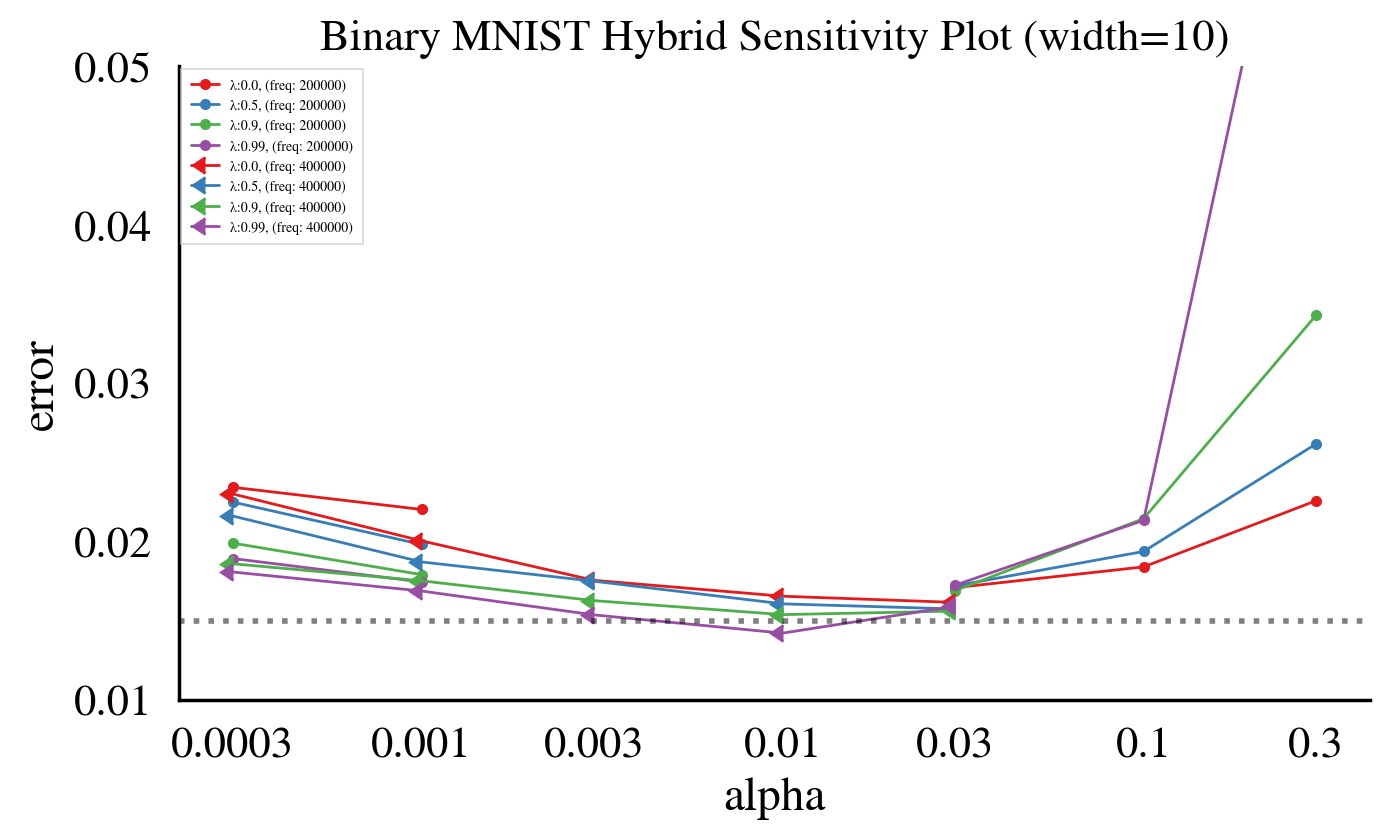

In [14]:
markers = ['.',8,'s','p','*','h']
marker_idx = 0
width=10

plt_name = f'Binary MNIST Hybrid Sensitivity Plot (width=10)'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width={width}', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width={width} and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 400:
                all_errors.append(errors_list[400][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.01, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.show()

(0.0003, 0.0) :	 200000 	 [0.023909, 0.022182, 0.023385, 0.023633, 0.024268, 0.024851, 0.022886, 0.024269, 0.02273, 0.024995]
(0.0003, 0.5) :	 200000 	 [0.023266, 0.023398, 0.022245, 0.023212, 0.022441, 0.022725, 0.021459, 0.023159, 0.021612, 0.023625]
(0.0003, 0.9) :	 200000 	 [0.020339, 0.020379, 0.01943, 0.020843, 0.019232, 0.020723, 0.019066, 0.02068, 0.019195, 0.02195]
(0.0003, 0.99) :	 200000 	 [0.019833, 0.018904, 0.018688, 0.019016, 0.01856, 0.020529, 0.01803, 0.019579, 0.018306, 0.021001]
(0.001, 0.0) :	 200000 	 [0.022504, 0.022621, 0.022667, 0.022044, 0.022279, 0.021147, 0.019941, 0.021858, 0.022141, 0.022524]
(0.001, 0.5) :	 200000 	 [0.020214, 0.019152, 0.020498, 0.019347, 0.019339, 0.02058, 0.017729, 0.020124, 0.020477, 0.021241]
(0.001, 0.9) :	 200000 	 [0.019151, 0.017674, 0.017594, 0.017364, 0.017752, 0.018884, 0.017655, 0.018297, 0.01726, 0.0191]
(0.001, 0.99) :	 200000 	 [0.017775, 0.01735, 0.017239, 0.016862, 0.017377, 0.01878, 0.017529, 0.017523, 0.016942, 0.01825]

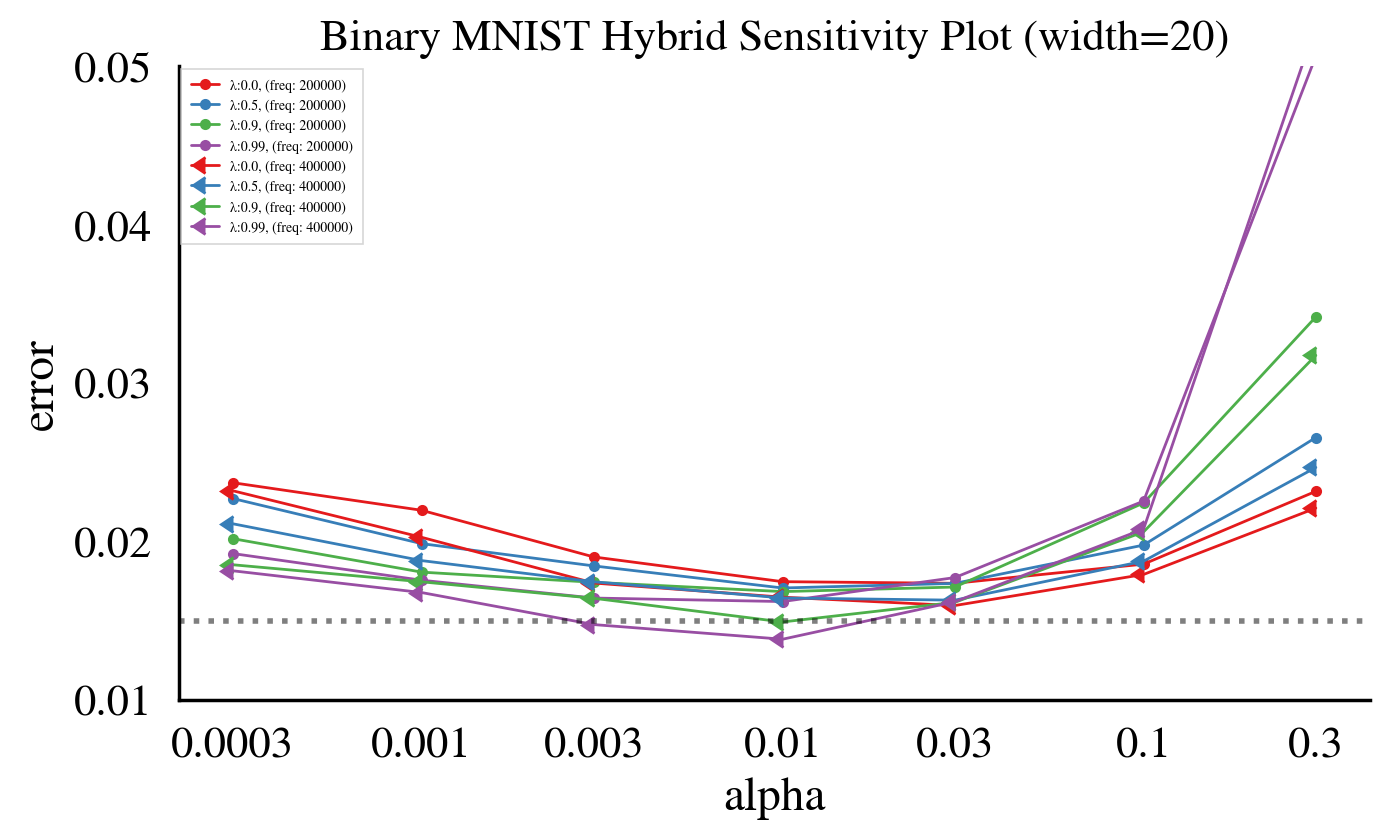

In [15]:
markers = ['.',8,'s','p','*','h']
marker_idx = 0
width=20

plt_name = f'Binary MNIST Hybrid Sensitivity Plot (width=20)'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width={width}', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width={width} and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 400:
                all_errors.append(errors_list[400][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.01, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.show()

	 Found 10 valid runs for [['width', 200], ['lambda', 0.99], ['step_size', 0.003]]
	 Found 5 valid runs for [['width', 1], ['lambda', 0.99], ['step_size', 0.003], ['freq', 200000]]
	 Found 10 valid runs for [['width', 20], ['lambda', 0.99], ['step_size', 0.01], ['freq', 400000]]


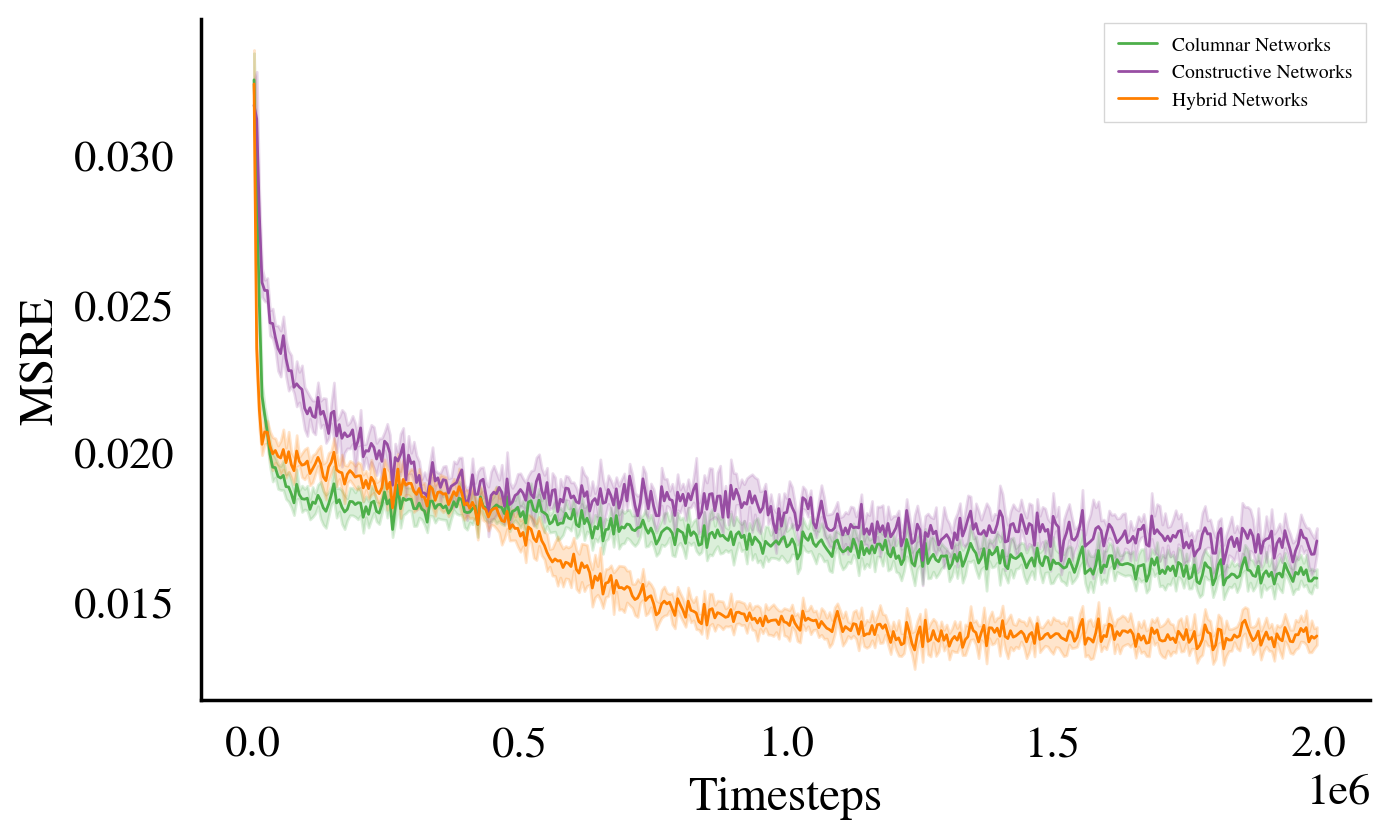

In [16]:

plt_name = f'Binary MNIST Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=5)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0
#conditions = [['step_size', 0.1],
#              ['lambda', 0.0],
#              ['truncation', 27]]
#plt_with_err("", 400, 0, db1, colors[color_idx], "Dense T-BPTT, k=27", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#conditions = [['lambda', 0.99],
#             ['step_size', 1e-2]]
#plt_with_err("", 98, 4500000, db4, colors[color_idx], "SnAp-1", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 200],
             ['lambda', 0.99],
             ['step_size', 0.003]]
plt_with_err("", 400,0, db1, colors[color_idx], "Columnar Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 1],
             ['lambda', 0.99],
             ['step_size', 0.003],
             ['freq', 200000]]
plt_with_err("", 400,0, db1, colors[color_idx], "Constructive Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 20],
             ['lambda', 0.99],
             ['step_size', 0.01],
             ['freq', 400000]]
plt_with_err("", 400,0, db1, colors[color_idx], "Hybrid Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [17]:
def plot_last_n_paper(obsall, predall, targets, n=400, colortarget=None, colorpred=None):
    fig, axs = plt.subplots(2,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()#(7.2,4.45)
    axs[-2].step(list(range(n)), targets[-n:], color=colortarget)
    axs[-1].step(list(range(n)), predall[-n:], color=colorpred)
    axs[-2].set_ylabel('Target')
    axs[-1].set_ylabel('Prediction')
    axs[-1].set_xlabel('Timestep')

    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
    return fig

In [18]:
def plot_last_n_paper(n=400, db=None, condition=None, colortarget=None, colorpred=None, axs=None, seed=0):
    # too lazy
    seed = seed
    pkey_col = 'run'
    if condition == []:
        r = pd.read_sql(f'select {pkey_col} from runs and seed=0', db.conn).values
    elif len(condition) == 1:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and seed={seed}', db.conn).values
    elif len(condition) == 2:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and seed={seed}', db.conn).values
    elif len(condition) == 3:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and seed={seed}', db.conn).values
    elif len(condition) == 4:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and seed={seed}', db.conn).values
    run = r[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db.conn)
    #obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,-2]
    target = pred_table.values[:,-1]
    axs.step(list(range(n)), target[-n:], color=colortarget, alpha=0.2)
    axs.step(list(range(n)), pred[-n:], color=colorpred)
    #axs.set_ylabel('Target')
    #axs.set_ylabel('Prediction')
    #axs.set_xlabel('Timestep')

    #for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
    #    ax.label_outer()
    return fig

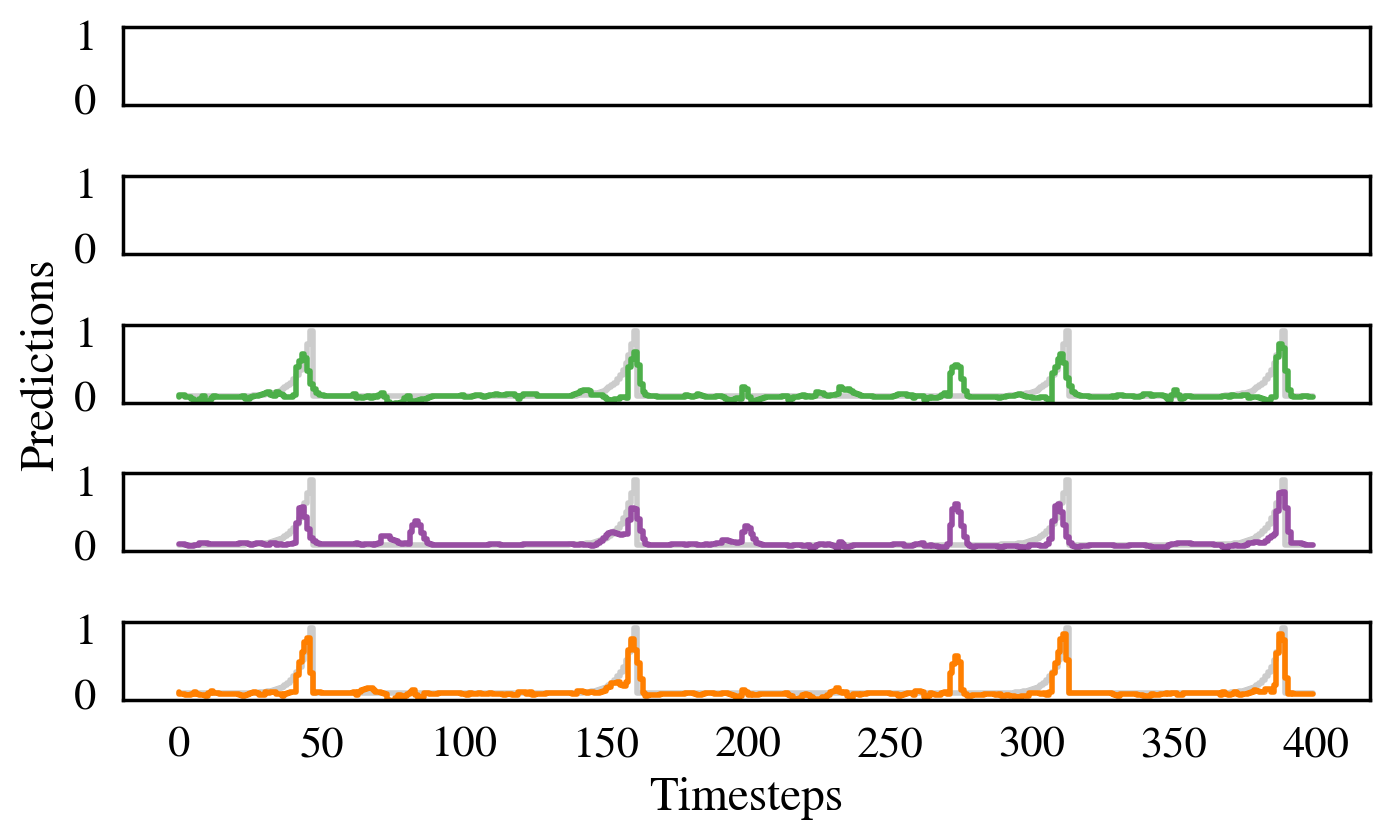

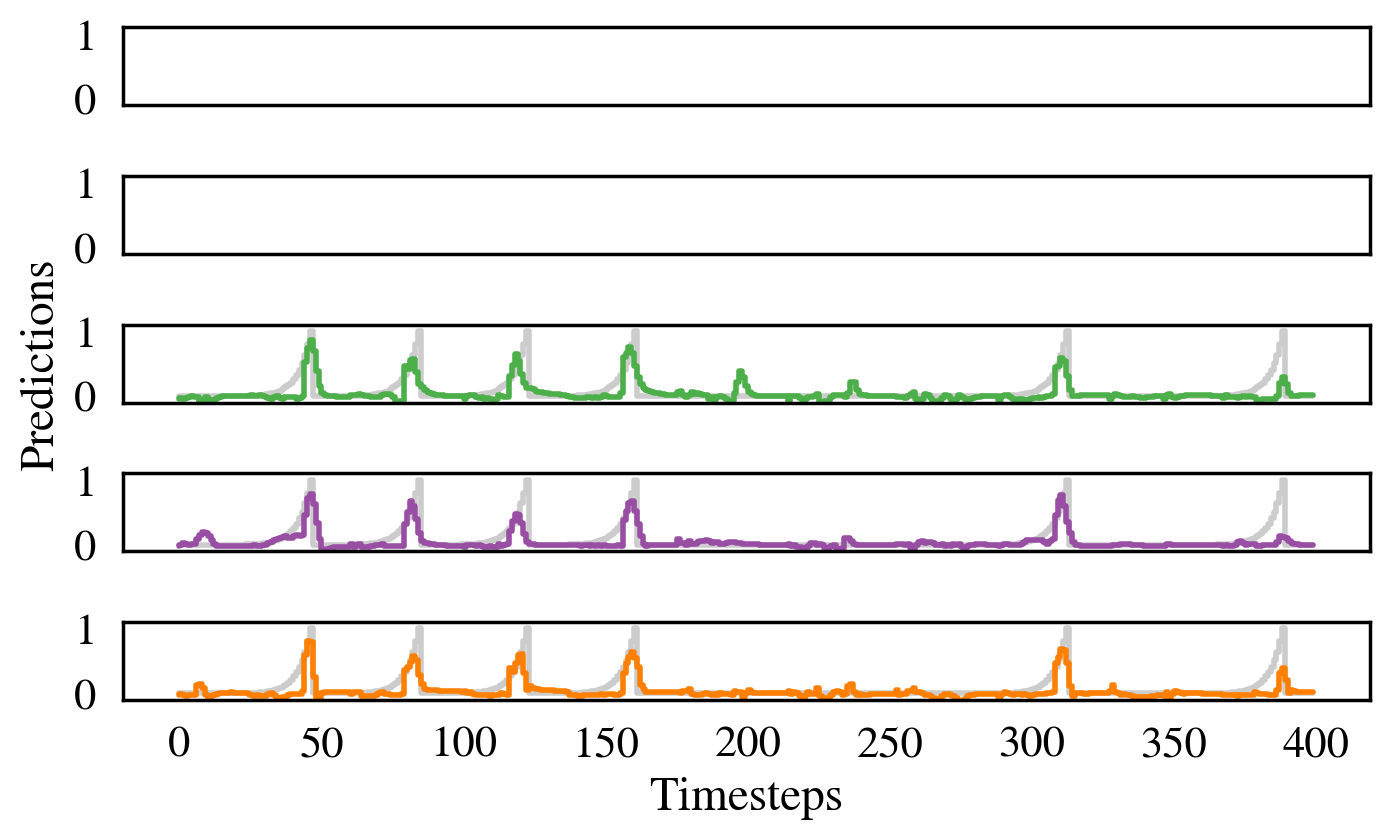

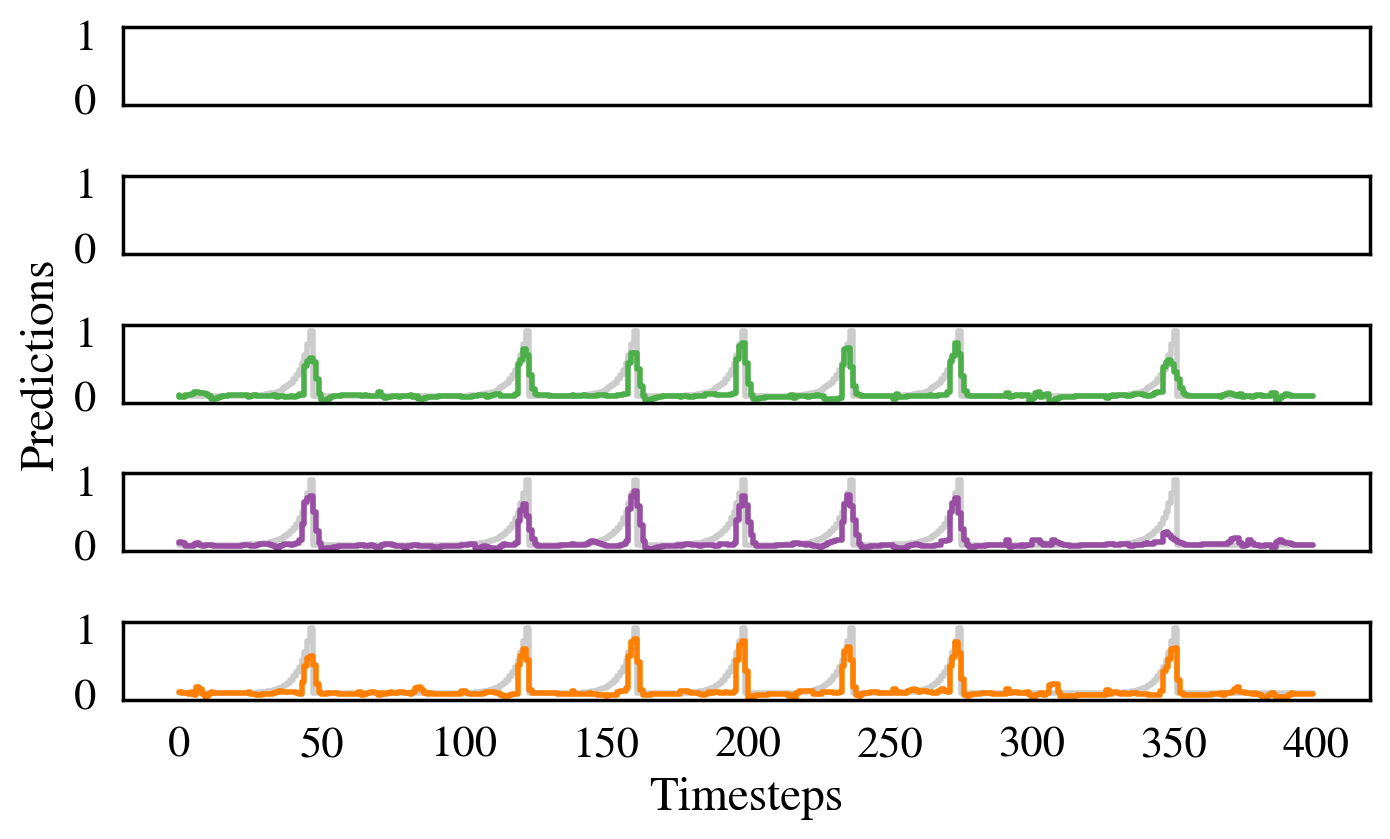

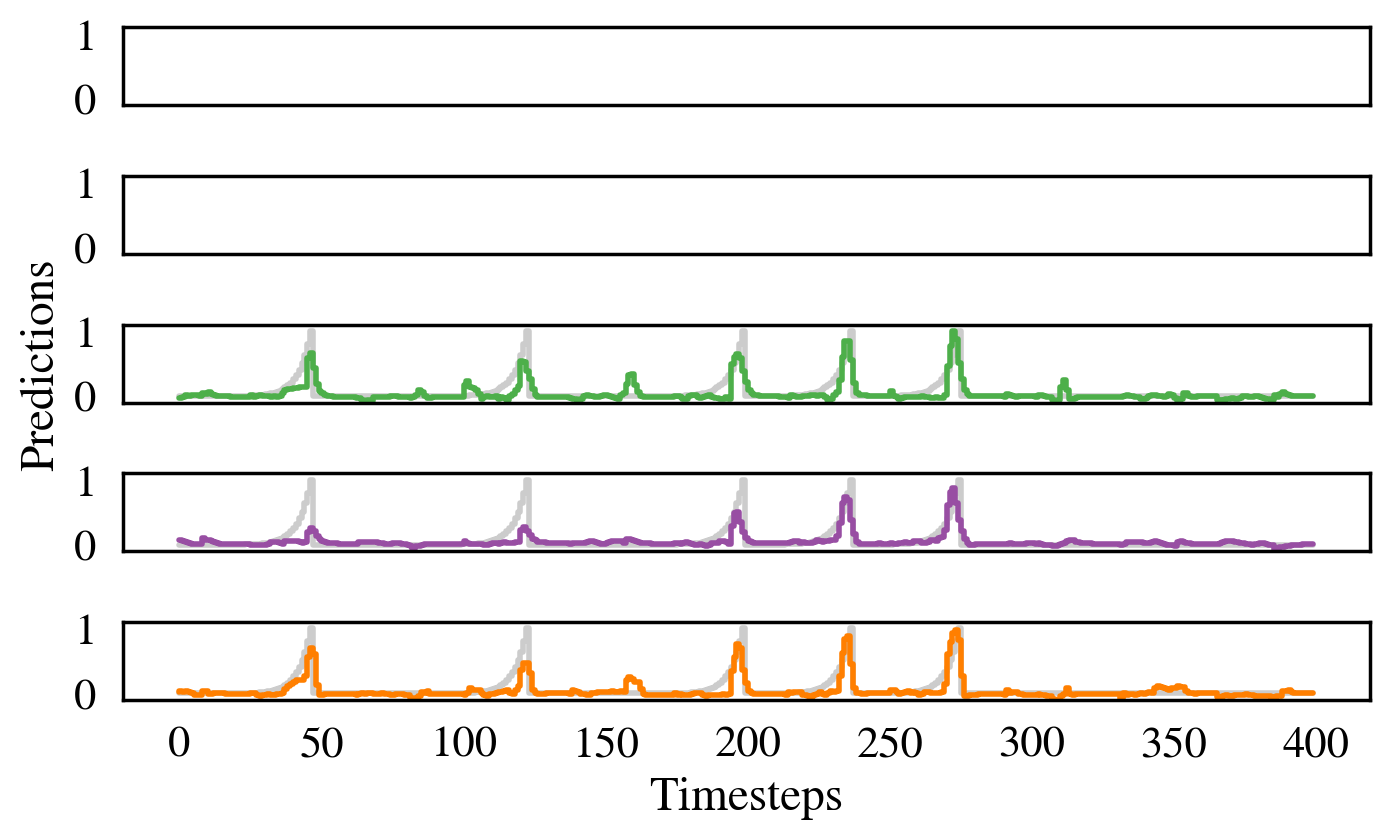

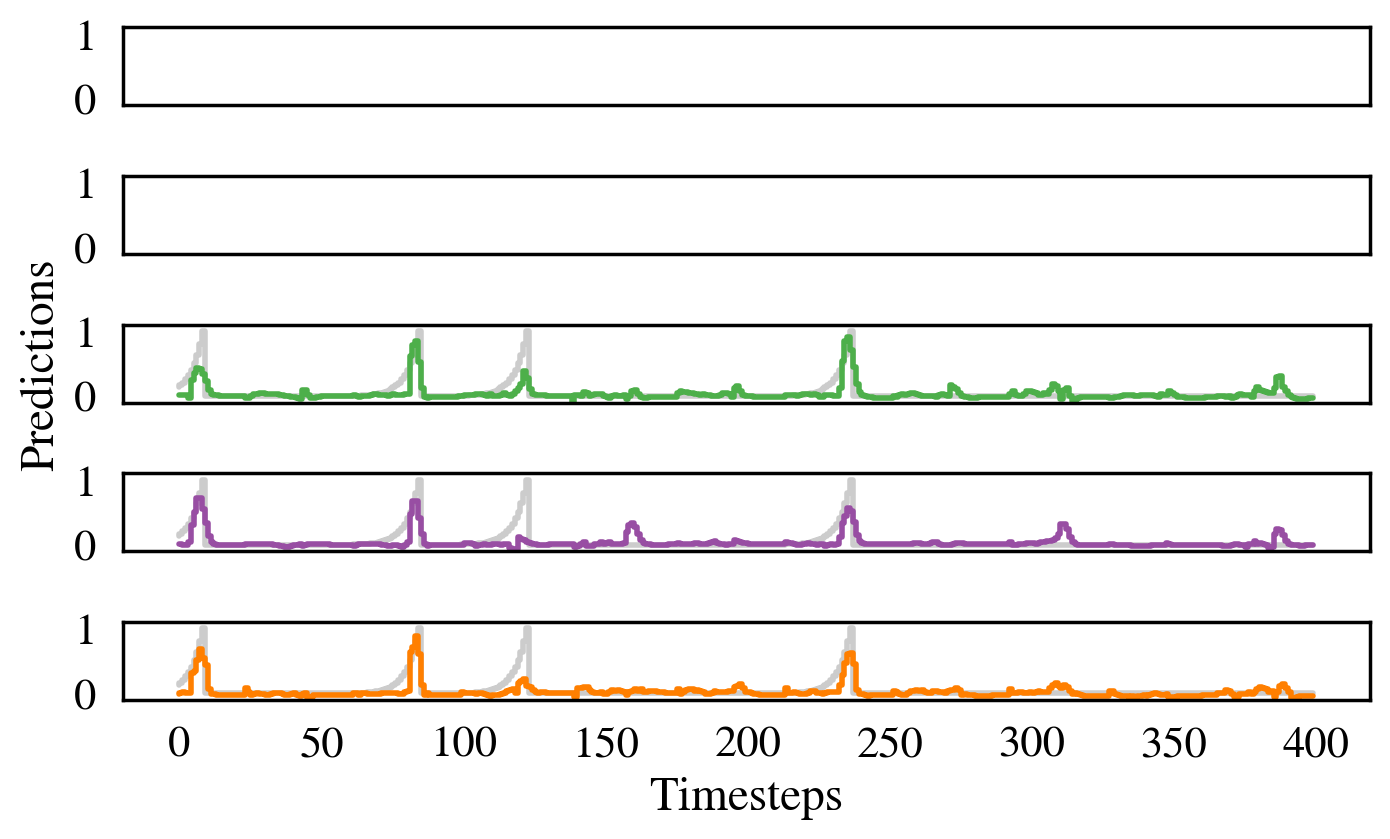

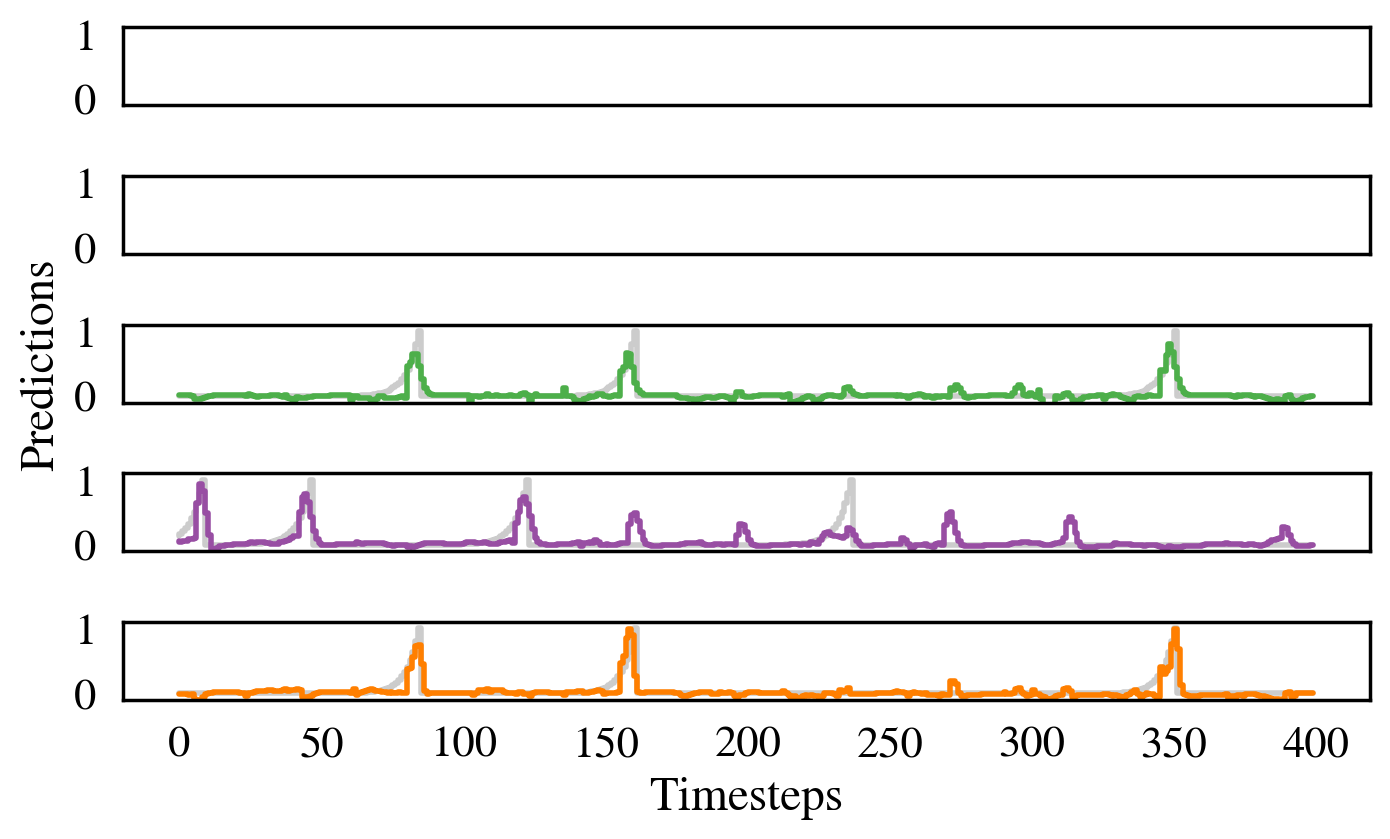

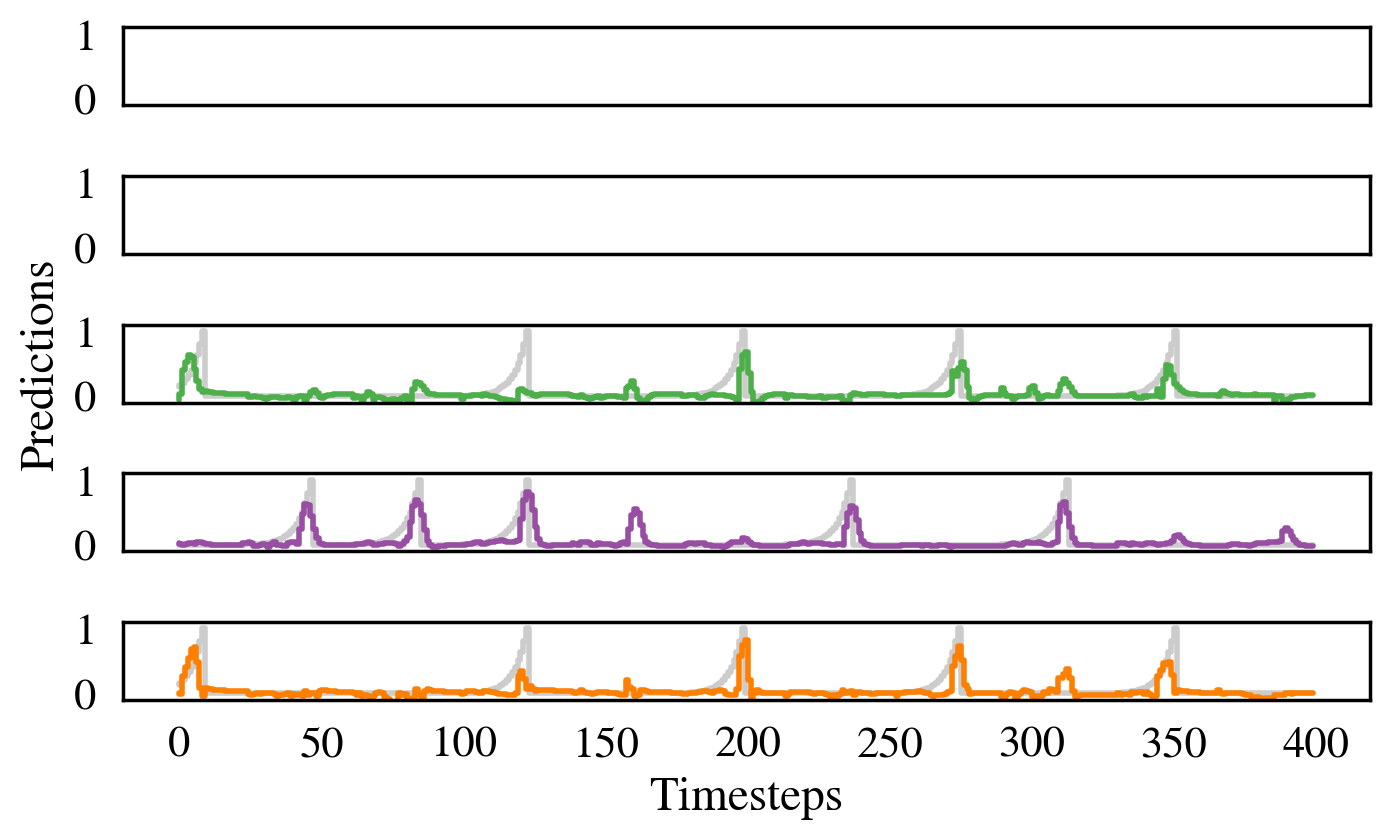

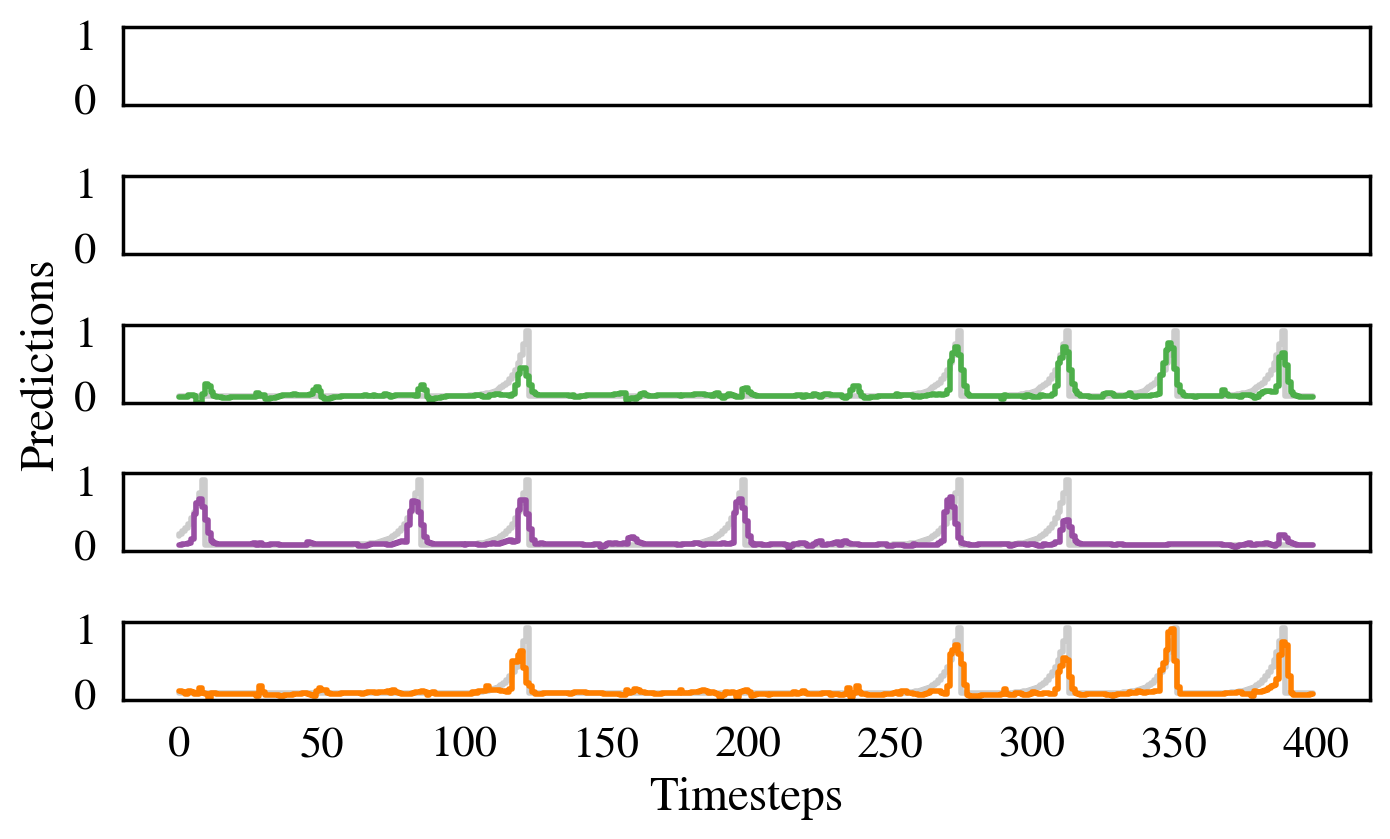

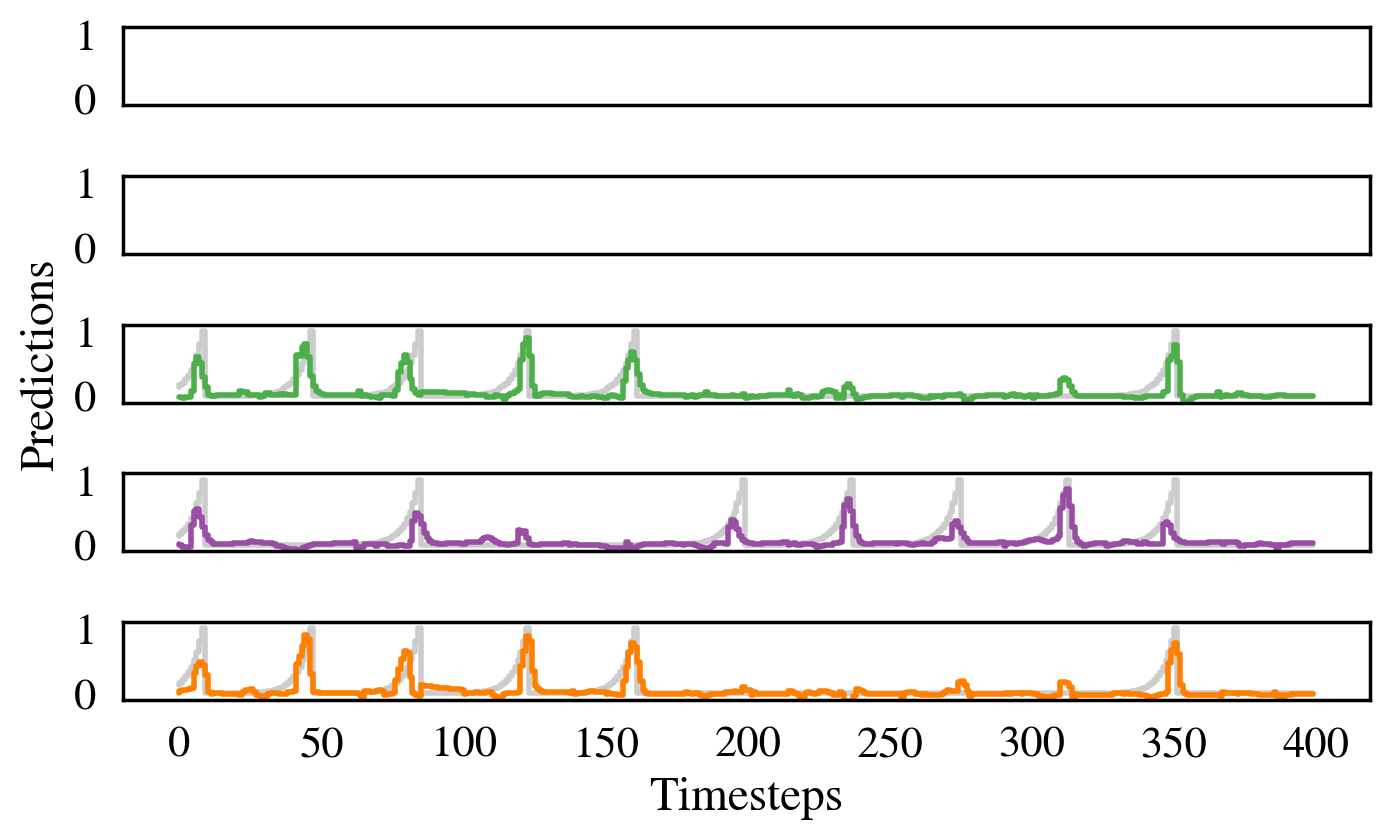

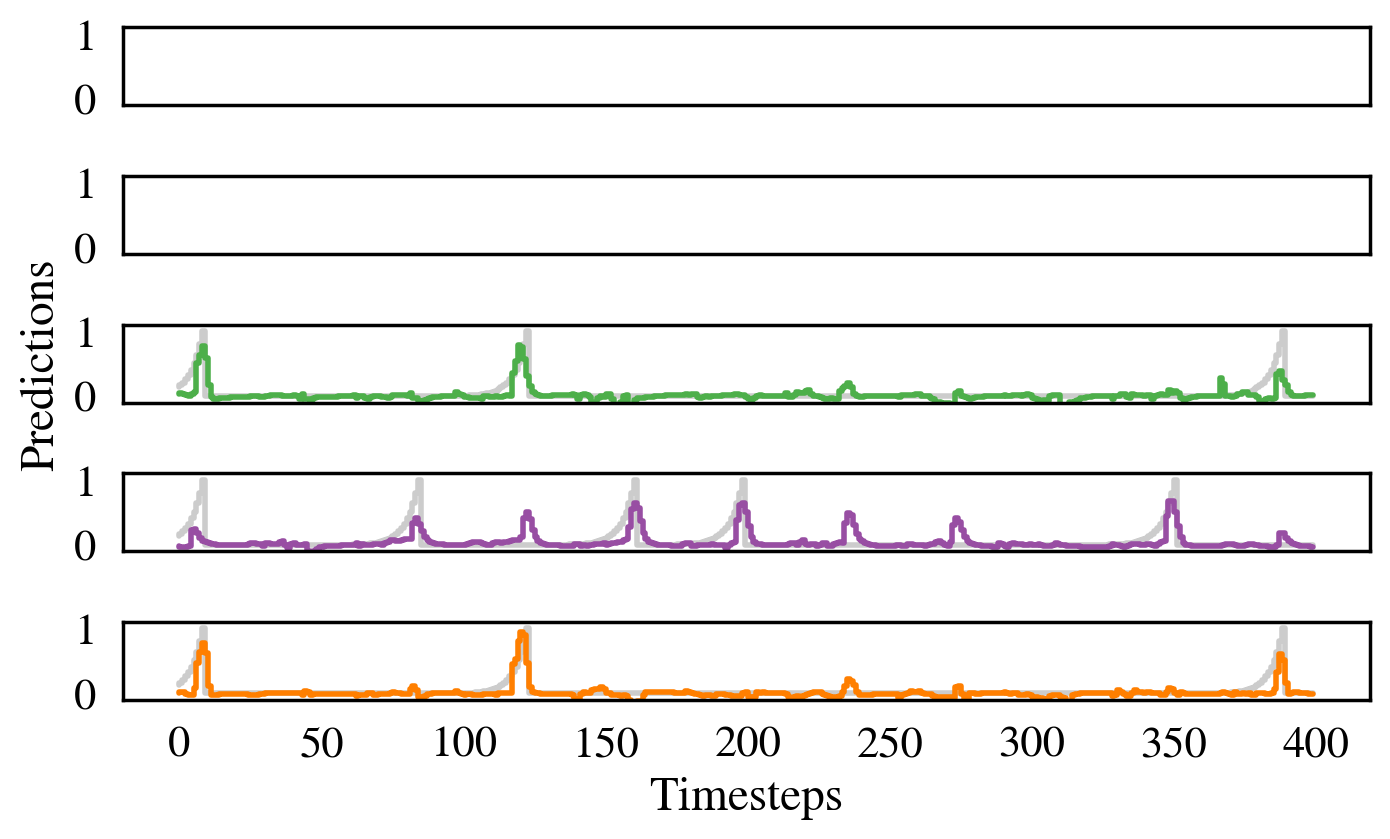

In [19]:
for seed in [0,1,2,3,4,5,6,7,8,9]:
    fig, axs = plt.subplots(5,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()
    """
    conditions = [['width', 20],
                 ['lambda', 0.99],
                 ['step_size', 1e-2],
                 ['freq', 800000]]
    colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
    run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
    obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,9]
    target = pred_table.values[:,10]
    plot_last_n_paper(obs, pred, target, colortarget=colors[6], colorpred=colors[4], axs=axs[0])
    plot_last_n_paper(obs, pred, target, colortarget=colors[7], colorpred=colors[4], axs=axs[1])
    #plt.suptitle('Hybrid NNs')
    """

    color_idx = 0
    #conditions = [['step_size', 0.1],
    #              ['lambda', 0.0],
    #              ['truncation', 27]]
    #plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[0])
    color_idx+=1

    #conditions = [['lambda', 0.99],
    #             ['step_size', 1e-2]]
    #plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[1])
    color_idx+=1

    conditions = [['width', 200],
                 ['lambda', 0.99],
                 ['step_size', 0.003]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[2], seed=seed)
    color_idx+=1

    conditions = [['width', 1],
                 ['lambda', 0.99],
                 ['step_size', 0.003],
                 ['freq', 200000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[3], seed=seed)
    color_idx+=1

    conditions = [['width', 20],
                 ['lambda', 0.99],
                 ['step_size', 0.01],
                 ['freq', 400000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[4], seed=seed)
    color_idx+=1
    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    axs[2].set_ylabel("Predictions")
    plt.xlabel("Timesteps")
    plt.savefig('figures/plt_mnist_preds.svg', bbox_inches='tight')